# Analyzing Time Series 
<hr style="border:2px solid black">

#### Load Packages

In [3]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)

# time-related stack
from datetime import datetime as dt

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# miscellaneous
import time
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import pmdarima as pm

from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams


**Predefined functions**

In [4]:
def qcd_variance(series,window=10):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    
    # first quartile
    Q1 = np.percentile(variances, 25, method='midpoint')
    
    # third quartile
    Q3 = np.percentile(variances, 75, method='midpoint')
    
    # quartile coefficient of dispersion 
    qcd = (Q3-Q1)/(Q3+Q1)
    
    return round(qcd,6)

In [5]:
def p_values(series):
    """
    returns p-values for ADF and KPSS Tests on a time series with explanation
    """

    # Explanation: p value from Augmented Dickey-Fuller (ADF) Test

    p_adf = adfuller(series, autolag="AIC")[1]
    result = adfuller(series, autolag="AIC")
    print(result)

    print('ADF Test Statistic: %.2f' % result[0])
    print('5%% Critical Value: %.2f' % result[4]['5%'])

    if  p_adf<=0.05 or abs(result[0])>abs(result[0]):    #or the absolute value of the test statistics is greater than the critical value
        print('ADF test. P-value is less than or equal to 0.05 or the absolute value of the test statistics is greater than the critical value, the time series is STATIONARY')
    else:
        print('Time series is NOT STATIONARY') 
        
    print('p-value: %.6f' % result[1])
    
    # Explanation: p value from Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

    p_kpss = kpss(series, regression="c", nlags="auto")[1]
    result = kpss(series)
    print(result)
    
    print('KPSS Test Statistic: %.2f' % result[0])
    print('5%% Critical Value: %.2f' % result[3]['5%'])

    if  p_kpss<=0.05 or abs(result[0])>abs(result[0]):    #or the absolute value of the test statistics is greater than the critical value
        print('KPSS test.  p-value is less than or equal to 0.05 or the absolute value of the test statistics is greater than the critical value, the time series is NOT STATIONARY.')
    else:
        print('Time series is STATIONARY')

    print('p-value: %.6f' % result[1])

    
    return round(p_adf,6), round(p_kpss,6)

In [6]:
def test_stationarity(series):
    """
    returns likely conclusions about series stationarity
    """
    # test heteroscedasticity with qcd
    qcd = qcd_variance(series)
    
    if qcd >= 0.50:
        print(f"\n non-stationary: heteroscedastic (qcd = {qcd}) \n")
    
    # test stationarity
    else:
        p_adf, p_kpss = p_values(series)
        
        # print p-values
        print( f"\n p_adf: {p_adf}, p_kpss: {p_kpss}" )

        
        if (p_adf < 0.01) and (p_kpss >= 0.05):
            print('\n stationary or seasonal-stationary')
            
        elif (p_adf >= 0.1) and (p_kpss < 0.05):
            print('\n difference-stationary')
            
        elif (p_adf < 0.1) and (p_kpss < 0.05):
            print('\n trend-stationary')
        
        else:
            print('\n non-stationary; no robust conclusions\n')

In [7]:
# create date index
#flights['date'] = flights.apply(
#    lambda x: dt.strptime(str(x['year'])+str(x['month']), '%Y%b'),
#    axis = 1
#)



## References

- Forecasting: Principles and Practice, R. J. Hyndman & G. Athanasopoulos,
[OTexts Free Online Book](https://otexts.com/fpp3/)
- [Different types of Time Series Decomposition](https://towardsdatascience.com/different-types-of-time-series-decomposition-396c09f92693)
- [Some excellent youtube videos](https://www.youtube.com/playlist?list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3)

In [8]:
data_temp = pd.read_csv('data/data.txt', sep=',', skiprows = 19,  skipinitialspace = True, parse_dates = [1])
data_temp.columns

Index(['SOUID', 'DATE', 'TG', 'Q_TG'], dtype='object')

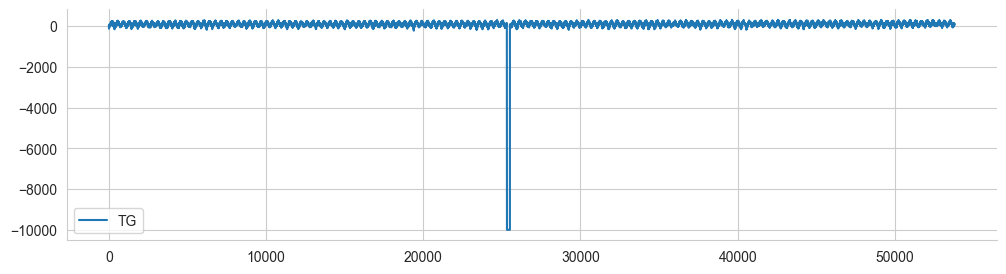

In [9]:
mpl.rc('figure',figsize=(12,3),dpi=100)
data_temp['TG'].plot(legend=True)
sns.despine()

In [10]:
data_missing = data_temp[data_temp['Q_TG'] == 9]
data_missing['DATE'].min()

Timestamp('1945-04-25 00:00:00')

In [11]:
data_missing = data_temp[data_temp['Q_TG'] == 9]
data_missing['DATE'].max()

Timestamp('1945-11-05 00:00:00')

In [12]:
missed = (data_missing['DATE'].max() - data_missing['DATE'].min()).days + 1
missed

195

In [13]:
reference_years = list(range(-5,6))
reference_years.remove(0)

reference_years

[-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]

In [14]:
def impute_temp(df, x):
    if x['Q_TG']==9:
        ref_dates = [x['DATE'] + relativedelta(years = y) for y in reference_years]
        # mean temperatue over the references dates
        temp_value = df[df['DATE'].isin(ref_dates)]['TG'].mean()
        # division by 10 to convert to celcius value
        return int(temp_value)/10
    # else just division by 10 to convert to celcius value
    return x['TG']/10

In [15]:
data_temp['TEMP'] = data_temp.apply(
    lambda x: impute_temp(data_temp, x),
    axis=1
)

In [17]:
data_temp.tail(90)

,SOUID,DATE,TG,Q_TG,TEMP
53691,100133,2023-01-01,141,0,14.1
53692,100133,2023-01-02,128,0,12.8
53693,100133,2023-01-03,51,0,5.1
53694,100133,2023-01-04,69,0,6.9
53695,100133,2023-01-05,81,0,8.1
...,...,...,...,...,...
53776,100133,2023-03-27,34,0,3.4
53777,100133,2023-03-28,30,0,3.0
53778,100133,2023-03-29,66,0,6.6
53779,100133,2023-03-30,114,0,11.4


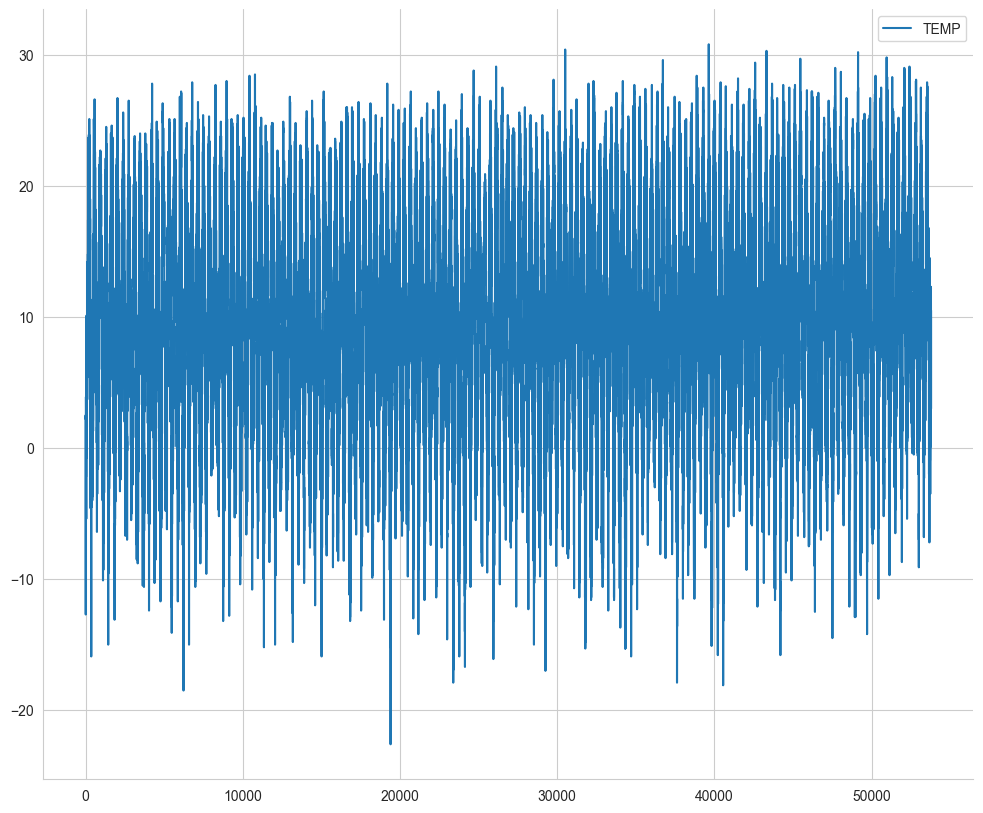

In [160]:
mpl.rc('figure',figsize=(12,10),dpi=100)
data_temp['TEMP'].plot(legend=True)
sns.despine()

In [161]:
clean_data =  data_temp.set_index('DATE')[['TEMP']]
clean_data.tail()

,TEMP
DATE,
2023-03-27,3.4
2023-03-28,3.0
2023-03-29,6.6
2023-03-30,11.4
2023-03-31,10.5


In [162]:
clean_data.to_csv('data/data_clean.csv')

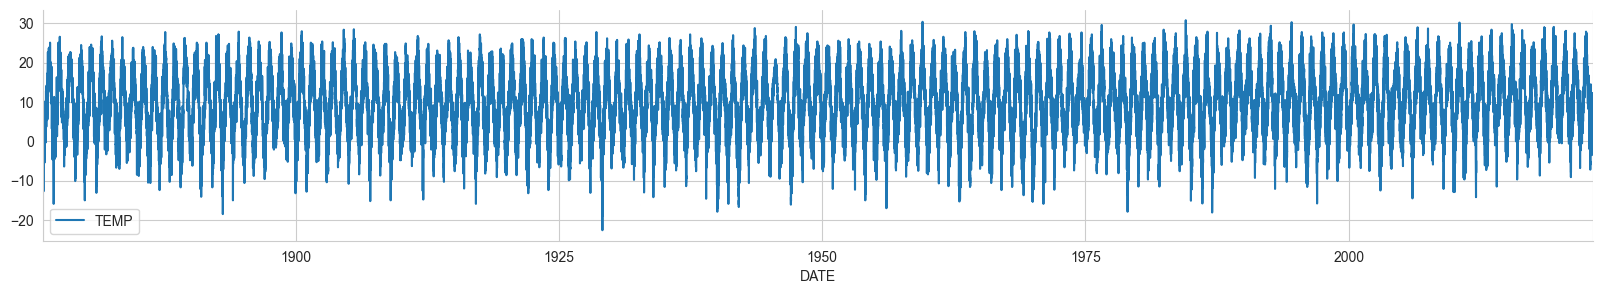

In [163]:
mpl.rc('figure',figsize=(20,3),dpi=100)
clean_data['TEMP'].plot(legend=True)
sns.despine()

In [164]:
train = clean_data[:'2023-01-01']
train.shape

(53692, 1)

In [165]:
test = clean_data['2022-12-31':]
test.shape

(91, 1)

In [166]:

train.to_csv('train_temp.csv')
test.to_csv('test_temp.csv')

In [167]:
from scipy.signal import savgol_filter

In [168]:
train['signal'] = savgol_filter(np.array(train['TEMP']), 99, 3, mode='nearest')
train['noise'] = train['TEMP'] - train['signal']
xtrain = train.reset_index()

X_trend_1 = xtrain[['DATE']]
y_trend_1 = xtrain['signal']
train.head()

,TEMP,signal,noise
DATE,,,
1876-01-01,2.2,-0.659391,2.859391
1876-01-02,2.5,-0.772946,3.272946
1876-01-03,0.3,-0.858296,1.158296
1876-01-04,-5.8,-1.025494,-4.774506
1876-01-05,-9.8,-1.151521,-8.648479


<Axes: xlabel='DATE'>

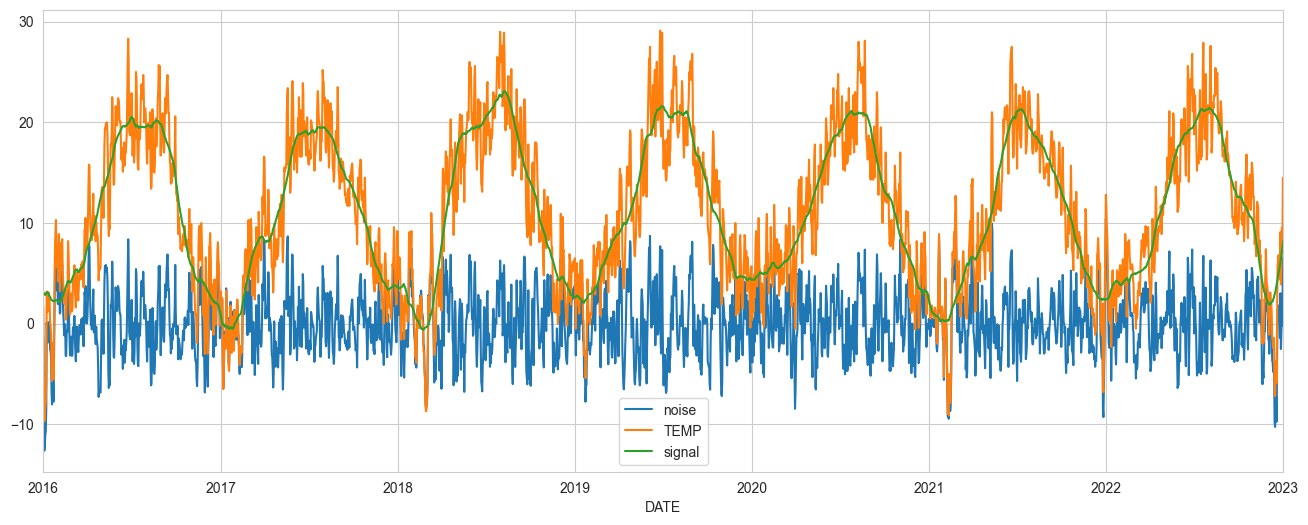

In [169]:
plt.rcParams['figure.figsize']=(16, 6)

train['noise']['2016-01-01':'2023-01-01'].plot(legend=True)
train['TEMP']['2016-01-01':'2023-01-01'].plot(legend=True)
train['signal']['2016-01-01':'2023-01-01'].plot(legend=True)

<Axes: xlabel='DATE'>

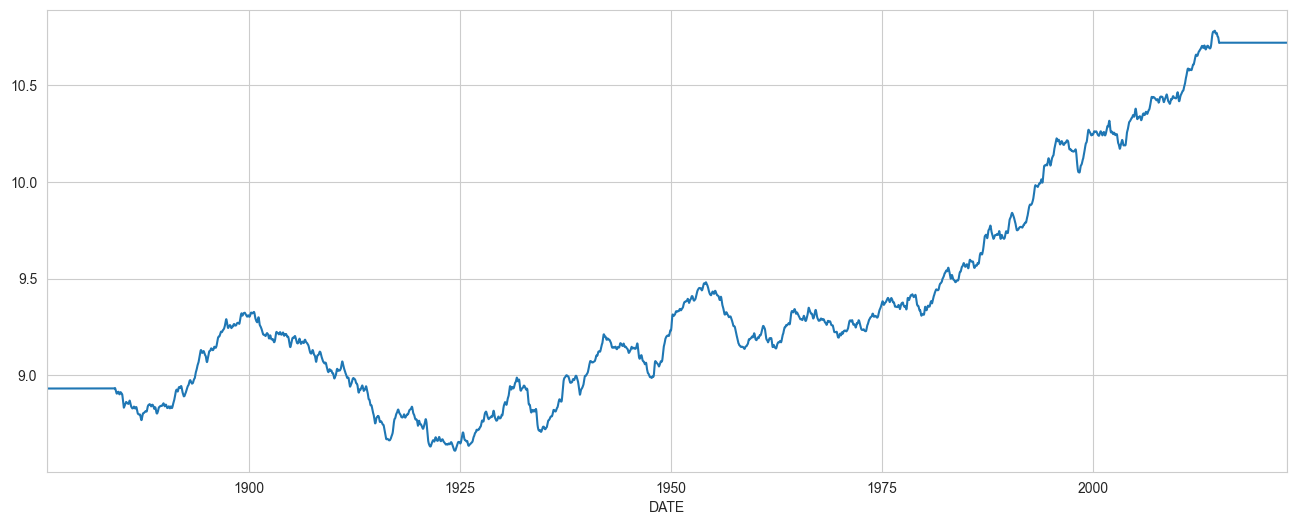

In [170]:

sd = seasonal_decompose(train['signal'], period=5844, model='addictive') #5844
# trand obsevation
train['trend'] = sd.trend


train['trend'] = train['trend'].fillna(method='ffill')
train['trend'] = train['trend'].fillna(method='bfill')
train['trend'].plot()

In [171]:
#train = train.reset_index()

In [172]:
train

,TEMP,signal,noise,trend
DATE,,,,
1876-01-01,2.2,-0.659391,2.859391,8.931707
1876-01-02,2.5,-0.772946,3.272946,8.931707
1876-01-03,0.3,-0.858296,1.158296,8.931707
1876-01-04,-5.8,-1.025494,-4.774506,8.931707
1876-01-05,-9.8,-1.151521,-8.648479,8.931707
...,...,...,...,...
2022-12-28,6.1,6.795879,-0.695879,10.719063
2022-12-29,9.5,7.181440,2.318560,10.719063
2022-12-30,7.4,7.580197,-0.180197,10.719063


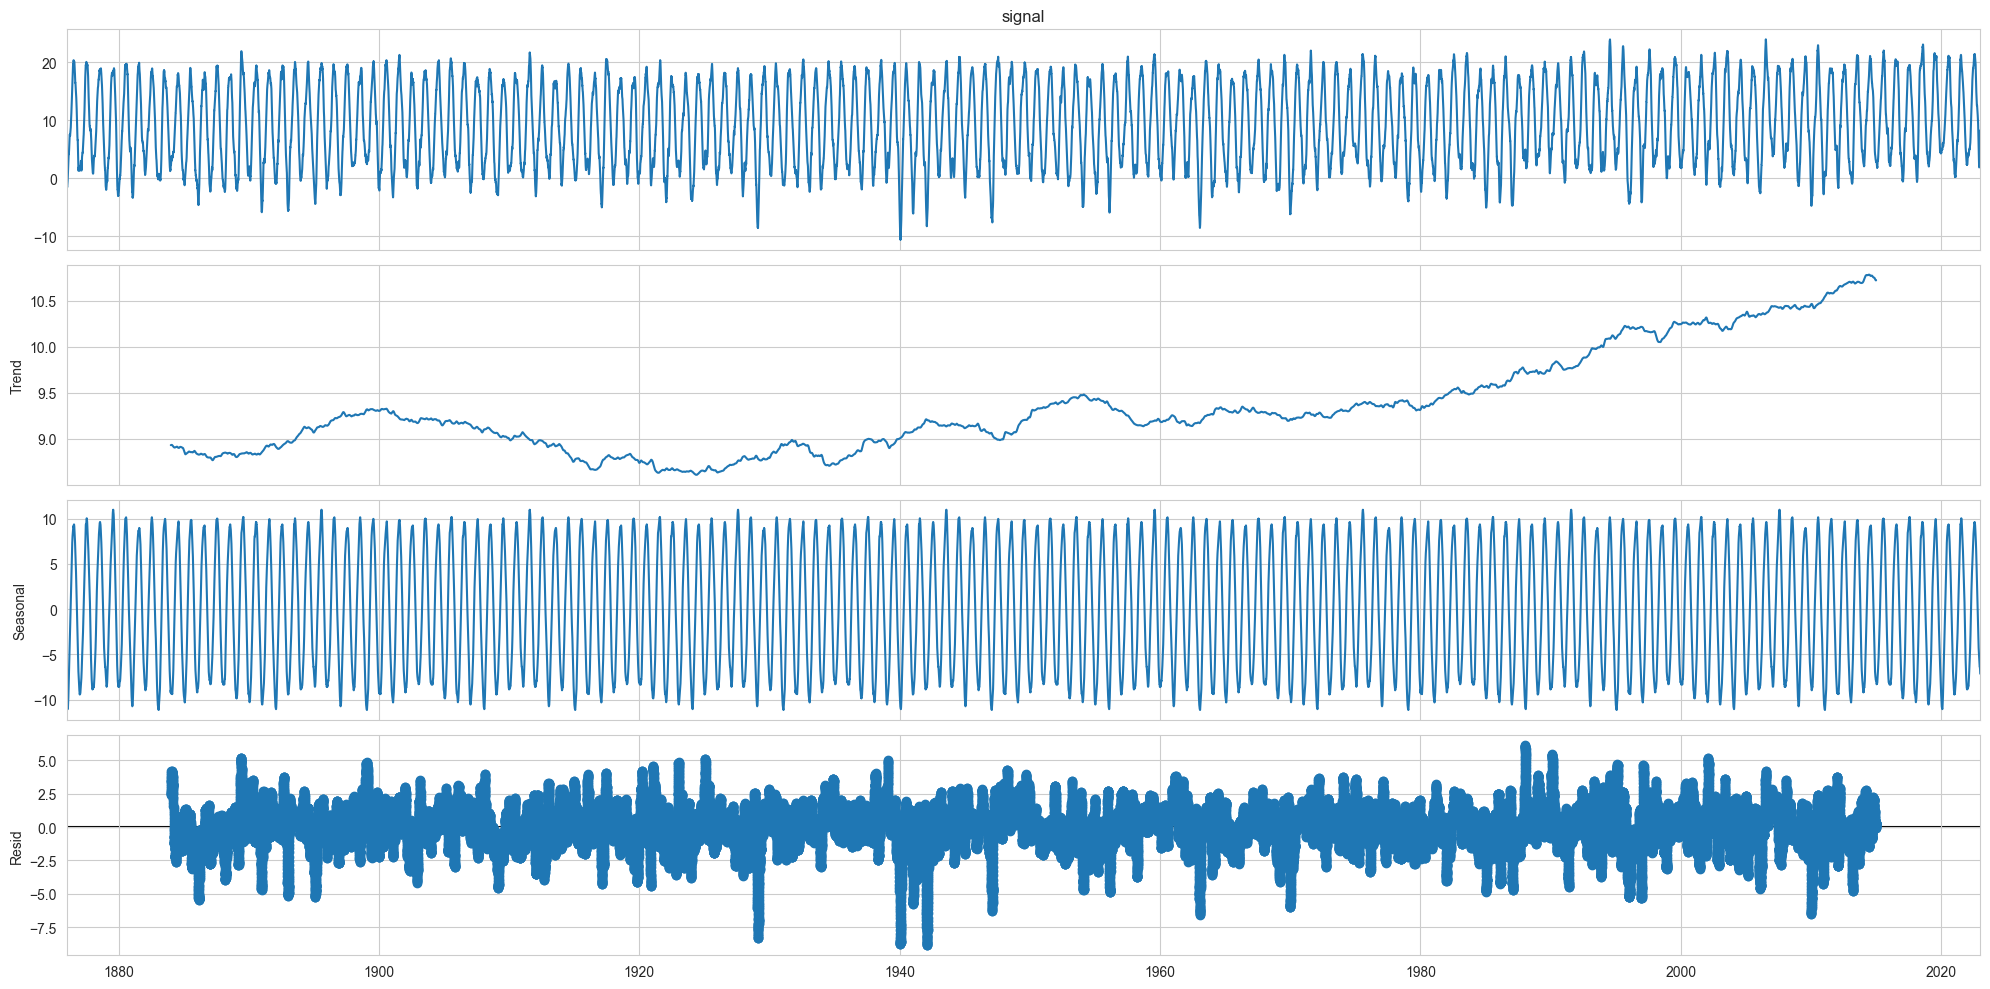

In [173]:
rcParams['figure.figsize'] = 20, 10

sd.plot()

plt.show()

In [ ]:
statsmodels.tsa.seasonal.seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)[source]

In [174]:
cv = TimeSeriesSplit(n_splits=3)

In [185]:
X_trend = train.reset_index()[['DATE']]

y_trend = train['trend']


X_train = train['DATE']
y_train = train['trend']

In [186]:
trend_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)
# fit model

trend_model.fit(X_trend, y_trend)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [187]:
train['trend_line'] = trend_model.predict(X_trend)

In [294]:
train

,TEMP,signal,noise,trend,trend_line,trend_sea,detrenned,rem,rem1
DATE,,,,,,,,,
1876-01-01,2.2,-0.659391,2.859391,8.931707,8.931707,-0.659391,-9.591098,-9.591098,-0.015715
1876-01-02,2.5,-0.772946,3.272946,8.931707,8.931707,-0.772946,-9.704653,-9.704653,-0.035132
1876-01-03,0.3,-0.858296,1.158296,8.931707,8.931707,-0.858296,-9.790003,-9.790003,-0.019057
1876-01-04,-5.8,-1.025494,-4.774506,8.931707,8.931707,-1.025494,-9.957201,-9.957201,-0.113930
1876-01-05,-9.8,-1.151521,-8.648479,8.931707,8.931707,-1.151521,-10.083229,-10.083229,-0.149370
...,...,...,...,...,...,...,...,...,...
2022-12-28,6.1,6.795879,-0.695879,10.719063,10.719063,6.795879,-3.923185,-3.923185,2.830112
2022-12-29,9.5,7.181440,2.318560,10.719063,10.719063,7.181440,-3.537624,-3.537624,3.295547
2022-12-30,7.4,7.580197,-0.180197,10.719063,10.719063,7.580197,-3.138867,-3.138867,3.804159


In [191]:
trend_model_noseasonal = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)
# fit model

trend_model_noseasonal.fit(X_trend_1, y_trend_1)
train['trend_sea'] = trend_model_noseasonal.predict(X_trend_1)

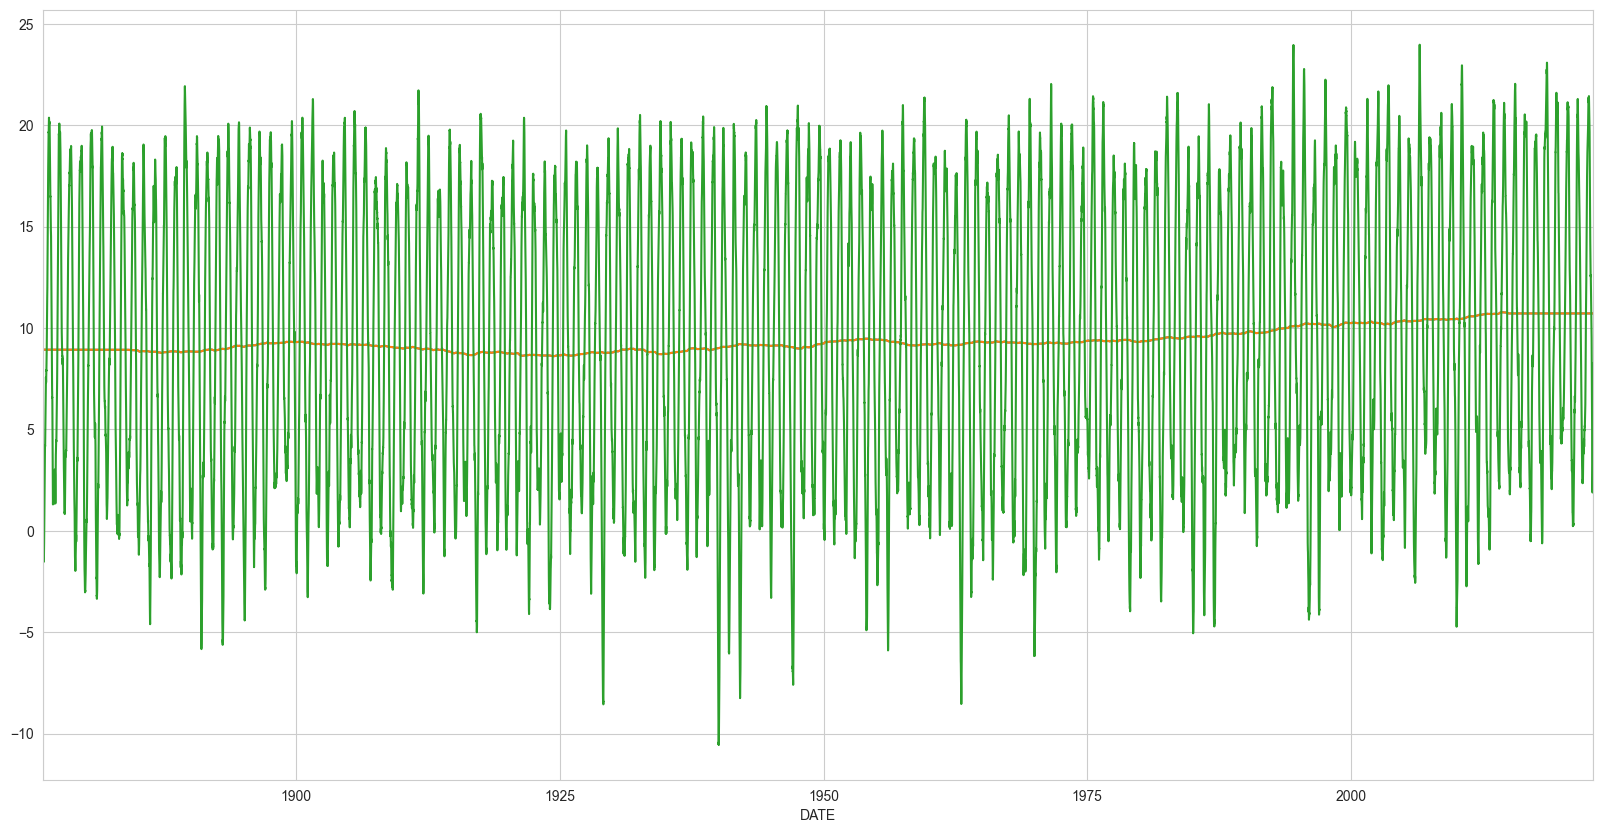

In [192]:
rcParams['figure.figsize'] = 20, 10

train['trend_line'].plot()
train['trend'].plot()
train['trend_sea'].plot()

plt.show()

In [193]:
train

,TEMP,signal,noise,trend,trend_line,trend_sea
DATE,,,,,,
1876-01-01,2.2,-0.659391,2.859391,8.931707,8.931707,-0.659391
1876-01-02,2.5,-0.772946,3.272946,8.931707,8.931707,-0.772946
1876-01-03,0.3,-0.858296,1.158296,8.931707,8.931707,-0.858296
1876-01-04,-5.8,-1.025494,-4.774506,8.931707,8.931707,-1.025494
1876-01-05,-9.8,-1.151521,-8.648479,8.931707,8.931707,-1.151521
...,...,...,...,...,...,...
2022-12-28,6.1,6.795879,-0.695879,10.719063,10.719063,6.795879
2022-12-29,9.5,7.181440,2.318560,10.719063,10.719063,7.181440
2022-12-30,7.4,7.580197,-0.180197,10.719063,10.719063,7.580197


In [194]:
train['detrenned'] = train['signal'] - train['trend_line']

In [195]:
train.shape

(53692, 7)

In [196]:
arima_model_noise = pm.auto_arima(
    train['noise'],
    seasonality = False,
    stationarity =  False,
    d=None,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=237731.995, Time=5.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=281840.809, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=239391.629, Time=0.95 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=250076.675, Time=2.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281838.816, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=237730.047, Time=1.99 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=241674.175, Time=3.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=237728.060, Time=2.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=237730.045, Time=4.85 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=237809.359, Time=1.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=237726.061, Time=1.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=250074.680, Time=0.98 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=239389.630, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=237728.046, Time=2.34 sec
 ARIM

In [197]:
arima_model_noise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                53692
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -118860.030
Date:                Fri, 12 May 2023   AIC                         237726.061
Time:                        13:26:32   BIC                         237752.734
Sample:                    01-01-1876   HQIC                        237734.389
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6351      0.004    157.176      0.000       0.627       0.643
ma.L1          0.2370      0.005     46.165      0.000       0.227       0.247
sigma2         4.9017      0.027    183.510      0.000       4.849       4.954
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               884.48
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [279]:

train['rem'] = train['detrenned']
train
trend = 10.719063

In [215]:
test_stationarity(train['signal'])


 non-stationary: heteroscedastic (qcd = 0.782226) 



In [216]:
test_stationarity(train['trend'])


 non-stationary: heteroscedastic (qcd = 0.92862) 



In [200]:
test_stationarity(train['noise'])

(-60.425287685099406, 0.0, 58, 53633, {'1%': -3.4304719326348807, '5%': -2.8615938918009034, '10%': -2.566798684809249}, 233571.61314832728)
ADF Test Statistic: -60.43
5% Critical Value: -2.86
ADF test. P-value is less than or equal to 0.05 or the absolute value of the test statistics is greater than the critical value, the time series is STATIONARY
p-value: 0.000000
(0.00027958605099164636, 0.1, 9, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.00
5% Critical Value: 0.46
Time series is STATIONARY
p-value: 0.100000

 p_adf: 0.0, p_kpss: 0.1

 stationary or seasonal-stationary


In [217]:
test_stationarity(train['rem'])


 non-stationary: heteroscedastic (qcd = 0.765862) 



In [201]:
test_stationarity(train['detrenned'])


 non-stationary: heteroscedastic (qcd = 0.782234) 



<Axes: xlabel='DATE'>

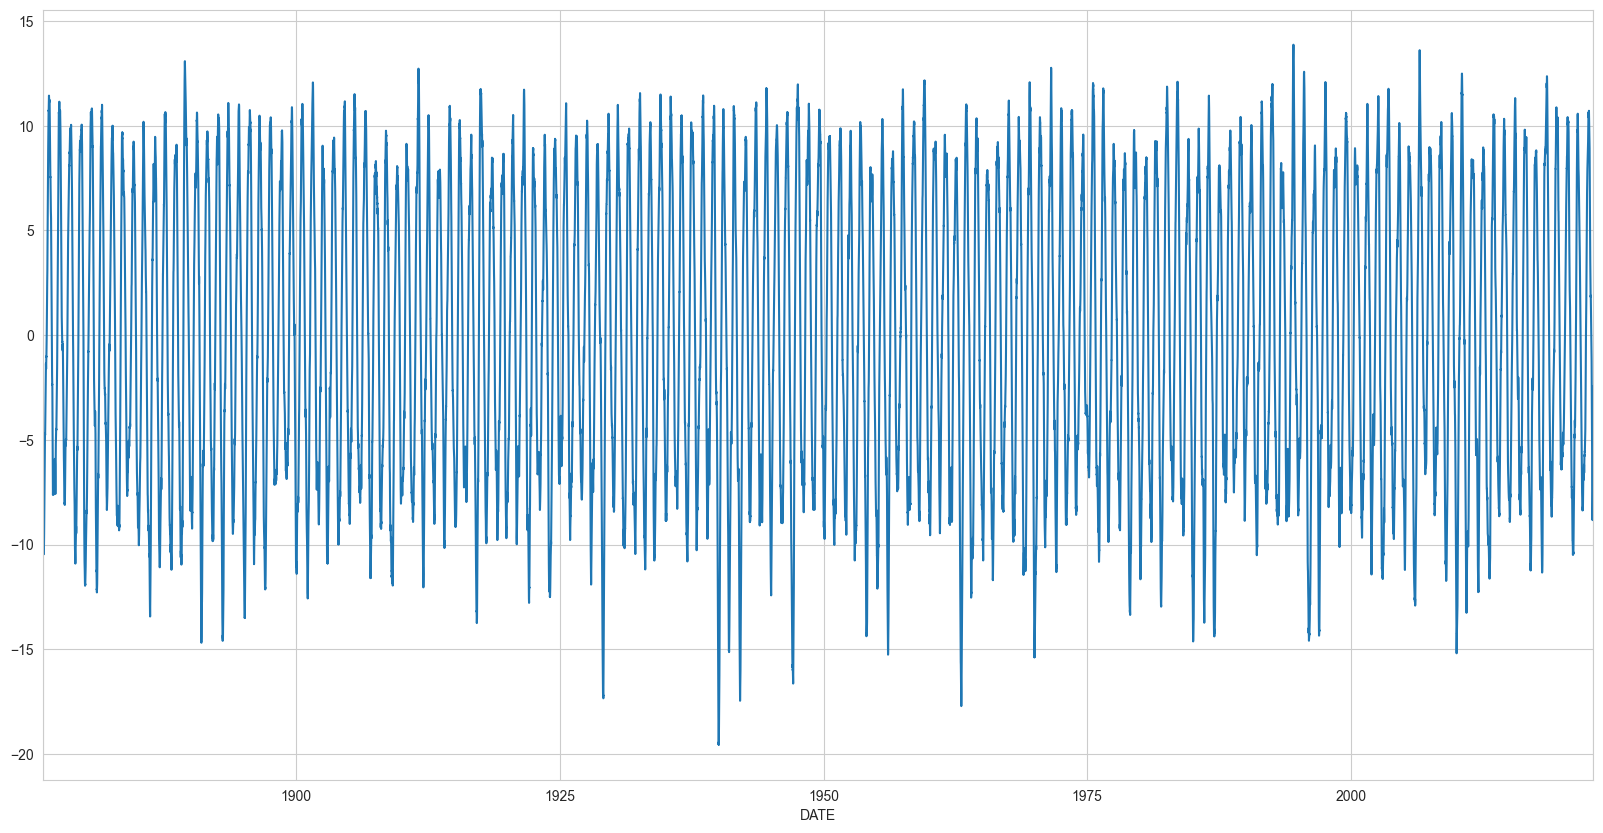

In [202]:
train['detrenned'].plot()

In [203]:
import statsmodels.api as sm

In [1]:
# Определение модели ARIMA
sarima_model_seasonal = sm.tsa.statespace.SARIMAX(train['detrenned'], order=(1,0,1), seasonal_order=(2,0,2,12))


NameError: name 'sm' is not defined

In [208]:

# Обучение модели
result = sarima_model_seasonal.fit()

# Вывод результатов
print(result.summary())



                                        SARIMAX Results                                        
Dep. Variable:                               detrenned   No. Observations:                53692
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood               68697.248
Date:                                 Fri, 12 May 2023   AIC                        -137380.495
Time:                                         13:30:47   BIC                        -137318.258
Sample:                                     01-01-1876   HQIC                       -137361.064
                                          - 01-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.000   7450.669      0.000       0.999       1

In [275]:
predict = result.get_prediction()
predict_ci = predict.conf_int()
forecast = result.forecast(steps = 10)
forecast.columns = ['date', 'temp']
forecast


2023-01-02   -2.288385
2023-01-03   -2.291262
2023-01-04   -2.296748
2023-01-05   -2.301275
2023-01-06   -2.300391
2023-01-07   -2.300755
2023-01-08   -2.288053
2023-01-09   -2.272687
2023-01-10   -2.259267
2023-01-11   -2.242998
Freq: D, Name: predicted_mean, dtype: float64

In [264]:
forecast_noise = arima_model_noise.predict()
forecast_noise.shape

(10,)

In [291]:
x_test = pd.DataFrame(forecast_noise, index=None)
x_test1 = pd.DataFrame(forecast, index=None)
x_test = x_test.reset_index()
x_test.columns = ['date', 'temp_noise']
x_test1 = x_test1.reset_index()
x_test1.columns = ['date', 'temp_detr']
x_test['detrenned'] = x_test1['temp_detr']


In [289]:
forecast

2023-01-02   -2.288385
2023-01-03   -2.291262
2023-01-04   -2.296748
2023-01-05   -2.301275
2023-01-06   -2.300391
2023-01-07   -2.300755
2023-01-08   -2.288053
2023-01-09   -2.272687
2023-01-10   -2.259267
2023-01-11   -2.242998
Freq: D, Name: predicted_mean, dtype: float64

In [293]:
x_test['trend'] = trend
x_test['sum'] = x_test['detrenned'] + x_test['trend'] + x_test['temp_noise']
x_test.head(5)

,date,temp_noise,detrenned,trend,sum
0,2023-01-02,3.682657,-2.288385,10.719063,12.113335
1,2023-01-03,2.338680,-2.291262,10.719063,10.766481
2,2023-01-04,1.485184,-2.296748,10.719063,9.907499
3,2023-01-05,0.943170,-2.301275,10.719063,9.360958
4,2023-01-06,0.598962,-2.300391,10.719063,9.017634


In [261]:
forecast

2023-01-02 00:00:00    -2.288385
2023-01-03 00:00:00    -2.291262
2023-01-04 00:00:00    -2.296748
2023-01-05 00:00:00    -2.301275
2023-01-06 00:00:00    -2.300391
2023-01-07 00:00:00    -2.300755
2023-01-08 00:00:00    -2.288053
2023-01-09 00:00:00    -2.272687
2023-01-10 00:00:00    -2.259267
2023-01-11 00:00:00    -2.242998
trend_line             10.719063
Name: predicted_mean, dtype: float64

In [135]:
predict_ci

,lower detrenned,upper detrenned
0,-8.335673,8.335673
1,-9.762609,-9.415427
2,-9.908339,-9.603861
3,-9.952271,-9.661815
4,-10.198196,-9.913975
...,...,...
53687,-4.282236,-4.022797
53688,-3.910877,-3.651438
53689,-3.513346,-3.253907
53690,-3.091450,-2.832011


In [90]:
'''
arima_model = pm.sarima(
    train['detrenned'],
    seasonality = True,
    stationarity =  False,
    d=None,
    start_p=0,
    max_p=2,
    m = 12,
    trace = True,
    n_jobs=-1
)

ARIMA(1,0,1)(2,0,2)[12]
'''

"\narima_model = pm.sarima(\n    train['detrenned'],\n    seasonality = True,\n    stationarity =  False,\n    d=None,\n    start_p=0,\n    max_p=2,\n    m = 12,\n    trace = True,\n    n_jobs=-1\n)\n\nARIMA(1,0,1)(2,0,2)[12]\n"

In [94]:
# auto-correlation plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

def auto_correlation_plot(series):
    """
    plots autocorrelations for a given series
    """
    mpl.rc('figure', figsize=(10,2), dpi=200)
    plot_acf(series, zero=False, lags=25)
    plt.xlabel('number of lags')
    plt.ylabel('autocorrelation')
    plt.show()

# partial auto-corremation plot 

def partial_auto_correlation_plot(series):
    """
    plots partial autocorrelations for a given series
    """
    mpl.rc('figure', figsize=(10,2), dpi=200)
    plot_pacf(series, zero=False, lags=25)
    plt.xlabel('number of lags')
    plt.ylabel('partial autocorrelation')

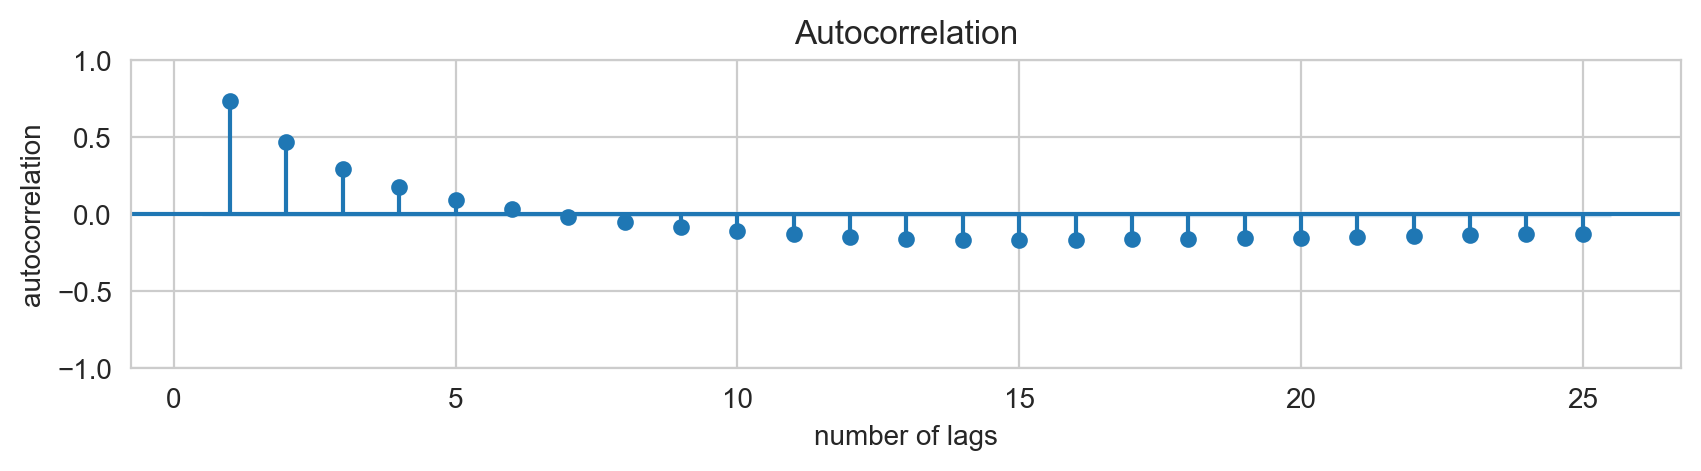

In [138]:
auto_correlation_plot(train['noise'])

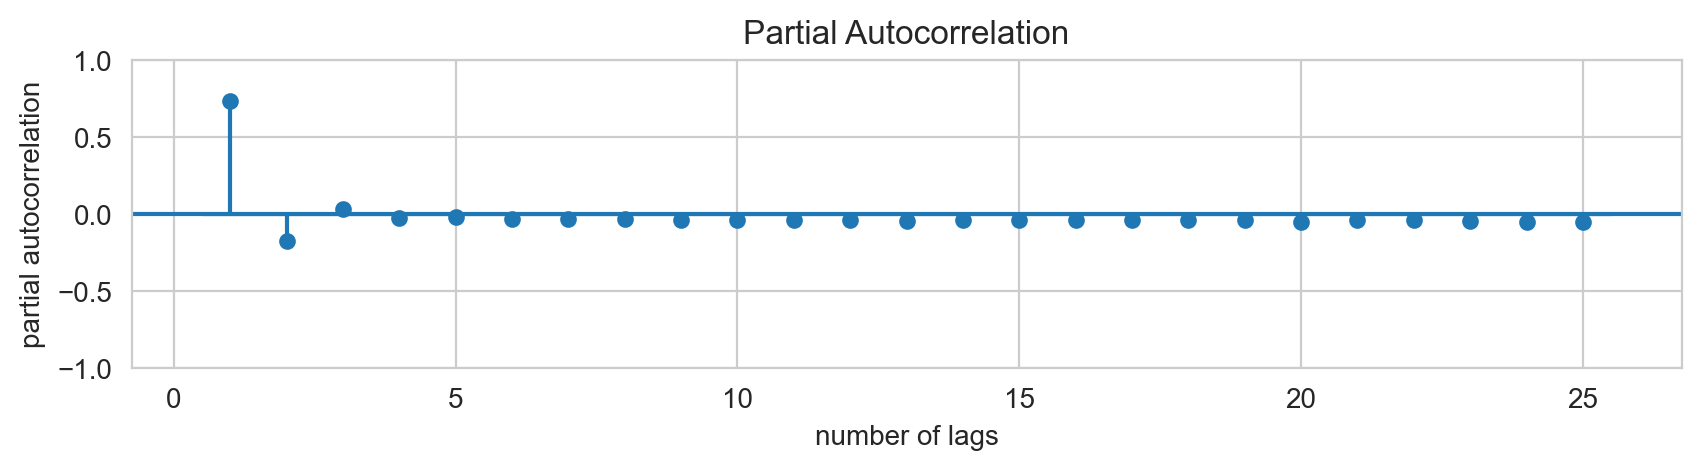

In [115]:
partial_auto_correlation_plot(train['noise'])

### Prediction Pipeline

In [98]:
test

,TEMP
DATE,
2022-12-31,14.5
2023-01-01,14.1
2023-01-02,12.8
2023-01-03,5.1
2023-01-04,6.9
...,...
2023-03-27,3.4
2023-03-28,3.0
2023-03-29,6.6


In [ ]:
def prepare_arima(data_temp):
    '''
    Pipeline for data preparation
    '''
    data = data_temp.copy()
    data['signal'] = savgol_filter(np.array(data['TEMP']), 99, 3, mode='nearest')
    data['noise'] = data['TEMP'] - data['signal']
    xtrain = data.reset_index()
    sd = seasonal_decompose(data['signal'], period=5844, model='addictive') #5844
    # trand obsevation
    data['trend'] = sd.trend


    data['trend'] = data['trend'].fillna(method='ffill')
    data['trend'] = data['trend'].fillna(method='bfill')

    return data

In [ ]:
trend_model
arima_model_noise 
sarima_model_seasonal
#arima_model_rem

In [95]:
train

,DATE,TEMP,signal,noise,trend,trend_line,trend_sea,detrenned
0,1876-01-01,2.2,-0.659391,2.859391,8.931707,8.931707,-0.659391,-9.591098
1,1876-01-02,2.5,-0.772946,3.272946,8.931707,8.931707,-0.772946,-9.704653
2,1876-01-03,0.3,-0.858296,1.158296,8.931707,8.931707,-0.858296,-9.790003
3,1876-01-04,-5.8,-1.025494,-4.774506,8.931707,8.931707,-1.025494,-9.957201
4,1876-01-05,-9.8,-1.151521,-8.648479,8.931707,8.931707,-1.151521,-10.083229
...,...,...,...,...,...,...,...,...
53687,2022-12-28,6.1,6.795879,-0.695879,10.719063,10.719063,6.795879,-3.923185
53688,2022-12-29,9.5,7.181440,2.318560,10.719063,10.719063,7.181440,-3.537624
53689,2022-12-30,7.4,7.580197,-0.180197,10.719063,10.719063,7.580197,-3.138867
53690,2022-12-31,14.5,7.944125,6.555875,10.719063,10.719063,7.944125,-2.774938
